# Exterior Algebra: A Computational Introduction

## 1. Introduction

**Exterior algebra** (also known as **Grassmann algebra**) is a fundamental algebraic structure that extends the notion of vectors to include higher-dimensional objects called **multivectors**. It provides the mathematical foundation for differential forms, determinants, and many concepts in modern physics and geometry.

### Historical Context

Hermann Grassmann introduced exterior algebra in his 1844 work *Die lineale Ausdehnungslehre*. Despite initial obscurity, it has become indispensable in:
- Differential geometry and topology
- General relativity and gauge theories
- Computer graphics and computational geometry
- Robotics and mechanics

## 2. Mathematical Foundations

### 2.1 The Wedge Product

Given a vector space $V$ over a field $\mathbb{F}$ with basis $\{e_1, e_2, \ldots, e_n\}$, the **exterior algebra** $\Lambda(V)$ is constructed using the **wedge product** (or exterior product) $\wedge$.

The wedge product satisfies two fundamental properties:

1. **Anticommutativity**: For vectors $u, v \in V$:
   $$u \wedge v = -v \wedge u$$

2. **Alternating property**: For any vector $v \in V$:
   $$v \wedge v = 0$$

### 2.2 $k$-Vectors and Graded Structure

A **$k$-vector** (or $k$-blade) is an element of the form:
$$v_1 \wedge v_2 \wedge \cdots \wedge v_k$$

The exterior algebra decomposes as a **graded algebra**:
$$\Lambda(V) = \bigoplus_{k=0}^{n} \Lambda^k(V)$$

where $\Lambda^k(V)$ is the space of $k$-vectors with dimension $\binom{n}{k}$.

### 2.3 Basis for $\Lambda^k(V)$

For $V = \mathbb{R}^n$, the basis of $\Lambda^k(V)$ consists of:
$$\{e_{i_1} \wedge e_{i_2} \wedge \cdots \wedge e_{i_k} : 1 \leq i_1 < i_2 < \cdots < i_k \leq n\}$$

### 2.4 Geometric Interpretation

- **0-vectors**: Scalars
- **1-vectors**: Directed line segments (vectors)
- **2-vectors (bivectors)**: Oriented plane segments with area $\|u \wedge v\| = \|u\|\|v\|\sin\theta$
- **3-vectors (trivectors)**: Oriented volumes

### 2.5 Connection to Determinants

For vectors $v_1, \ldots, v_n \in \mathbb{R}^n$ with $v_i = \sum_j a_{ij} e_j$:
$$v_1 \wedge v_2 \wedge \cdots \wedge v_n = \det(A) \cdot e_1 \wedge e_2 \wedge \cdots \wedge e_n$$

where $A = (a_{ij})$ is the matrix with rows $v_i$.

## 3. Computational Implementation

We now implement exterior algebra operations in Python. We will represent $k$-vectors as dictionaries mapping basis element tuples to coefficients.

In [1]:
import numpy as np
from itertools import combinations
from typing import Dict, Tuple, List
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

class ExteriorAlgebra:
    """
    A class implementing exterior algebra operations on R^n.
    
    k-vectors are represented as dictionaries:
        {(i1, i2, ..., ik): coefficient, ...}
    where (i1, i2, ..., ik) is a strictly increasing tuple of basis indices.
    """
    
    def __init__(self, dim: int):
        """Initialize exterior algebra on R^dim."""
        self.dim = dim
    
    def vector_to_1form(self, v: np.ndarray) -> Dict[Tuple[int, ...], float]:
        """Convert a numpy vector to a 1-vector representation."""
        return {(i,): v[i] for i in range(len(v)) if abs(v[i]) > 1e-10}
    
    def _sign_of_permutation(self, perm: Tuple[int, ...]) -> int:
        """Compute the sign of the permutation needed to sort the tuple."""
        perm_list = list(perm)
        n = len(perm_list)
        sign = 1
        for i in range(n):
            for j in range(i + 1, n):
                if perm_list[i] > perm_list[j]:
                    sign *= -1
        return sign
    
    def _canonicalize(self, indices: Tuple[int, ...]) -> Tuple[Tuple[int, ...], int]:
        """
        Canonicalize a tuple of indices to increasing order.
        Returns (sorted_tuple, sign) where sign accounts for anticommutativity.
        Returns ((,), 0) if there are repeated indices (wedge = 0).
        """
        if len(indices) != len(set(indices)):
            return ((), 0)  # Repeated index: wedge product is zero
        sign = self._sign_of_permutation(indices)
        return (tuple(sorted(indices)), sign)
    
    def wedge(self, a: Dict[Tuple[int, ...], float], 
              b: Dict[Tuple[int, ...], float]) -> Dict[Tuple[int, ...], float]:
        """
        Compute the wedge product of two multivectors.
        
        Parameters:
        -----------
        a, b : Dict mapping basis tuples to coefficients
        
        Returns:
        --------
        Dict representing a ∧ b
        """
        result = {}
        
        for idx_a, coef_a in a.items():
            for idx_b, coef_b in b.items():
                # Concatenate indices
                combined = idx_a + idx_b
                
                # Canonicalize and get sign
                canonical, sign = self._canonicalize(combined)
                
                if sign != 0:  # Not zero (no repeated indices)
                    coef = sign * coef_a * coef_b
                    if canonical in result:
                        result[canonical] += coef
                    else:
                        result[canonical] = coef
        
        # Remove near-zero entries
        return {k: v for k, v in result.items() if abs(v) > 1e-10}
    
    def grade(self, mv: Dict[Tuple[int, ...], float], k: int) -> Dict[Tuple[int, ...], float]:
        """Extract the grade-k part of a multivector."""
        return {idx: coef for idx, coef in mv.items() if len(idx) == k}
    
    def scalar_mult(self, scalar: float, 
                    mv: Dict[Tuple[int, ...], float]) -> Dict[Tuple[int, ...], float]:
        """Multiply a multivector by a scalar."""
        return {k: scalar * v for k, v in mv.items()}
    
    def add(self, a: Dict[Tuple[int, ...], float], 
            b: Dict[Tuple[int, ...], float]) -> Dict[Tuple[int, ...], float]:
        """Add two multivectors."""
        result = dict(a)
        for k, v in b.items():
            result[k] = result.get(k, 0) + v
        return {k: v for k, v in result.items() if abs(v) > 1e-10}
    
    def bivector_norm(self, bv: Dict[Tuple[int, ...], float]) -> float:
        """Compute the norm of a bivector (represents oriented area)."""
        grade2 = self.grade(bv, 2)
        return np.sqrt(sum(c**2 for c in grade2.values()))
    
    def format_multivector(self, mv: Dict[Tuple[int, ...], float]) -> str:
        """Format a multivector for display."""
        if not mv:
            return "0"
        
        terms = []
        for idx in sorted(mv.keys(), key=lambda x: (len(x), x)):
            coef = mv[idx]
            if len(idx) == 0:
                terms.append(f"{coef:.4f}")
            else:
                basis_str = " ∧ ".join(f"e{i+1}" for i in idx)
                if abs(coef - 1) < 1e-10:
                    terms.append(basis_str)
                elif abs(coef + 1) < 1e-10:
                    terms.append(f"-{basis_str}")
                else:
                    terms.append(f"{coef:.4f}({basis_str})")
        
        return " + ".join(terms).replace("+ -", "- ")

# Initialize exterior algebra on R^3
EA = ExteriorAlgebra(3)
print("Exterior Algebra on R³ initialized.")

Exterior Algebra on R³ initialized.


## 4. Demonstrations

### 4.1 Anticommutativity and the Wedge Product

In [2]:
# Define two vectors in R^3
u = np.array([1.0, 2.0, 0.0])
v = np.array([0.0, 1.0, 3.0])

# Convert to 1-vectors
u_ext = EA.vector_to_1form(u)
v_ext = EA.vector_to_1form(v)

print("Vector u =", u)
print("Vector v =", v)
print()
print(f"u as 1-vector: {EA.format_multivector(u_ext)}")
print(f"v as 1-vector: {EA.format_multivector(v_ext)}")
print()

# Compute u ∧ v and v ∧ u
u_wedge_v = EA.wedge(u_ext, v_ext)
v_wedge_u = EA.wedge(v_ext, u_ext)

print(f"u ∧ v = {EA.format_multivector(u_wedge_v)}")
print(f"v ∧ u = {EA.format_multivector(v_wedge_u)}")
print()
print("Verification: u ∧ v = -(v ∧ u)? ", 
      all(abs(u_wedge_v.get(k, 0) + v_wedge_u.get(k, 0)) < 1e-10 
          for k in set(u_wedge_v) | set(v_wedge_u)))

Vector u = [1. 2. 0.]
Vector v = [0. 1. 3.]

u as 1-vector: e1 + 2.0000(e2)
v as 1-vector: e2 + 3.0000(e3)

u ∧ v = e1 ∧ e2 + 3.0000(e1 ∧ e3) + 6.0000(e2 ∧ e3)
v ∧ u = -e1 ∧ e2 - 3.0000(e1 ∧ e3) - 6.0000(e2 ∧ e3)

Verification: u ∧ v = -(v ∧ u)?  True


### 4.2 The Alternating Property: $v \wedge v = 0$

In [3]:
# Verify that v ∧ v = 0
v_wedge_v = EA.wedge(v_ext, v_ext)
print(f"v ∧ v = {EA.format_multivector(v_wedge_v)}")
print("This confirms the alternating property: v ∧ v = 0")

v ∧ v = 0
This confirms the alternating property: v ∧ v = 0


### 4.3 Triple Wedge Product and Volume

For three vectors in $\mathbb{R}^3$, the wedge product $u \wedge v \wedge w$ represents the oriented volume of the parallelepiped they span.

In [4]:
# Define three vectors
u = np.array([1.0, 0.0, 0.0])
v = np.array([1.0, 2.0, 0.0])
w = np.array([0.0, 1.0, 3.0])

u_ext = EA.vector_to_1form(u)
v_ext = EA.vector_to_1form(v)
w_ext = EA.vector_to_1form(w)

# Compute u ∧ v ∧ w
uv = EA.wedge(u_ext, v_ext)
uvw = EA.wedge(uv, w_ext)

print("Vectors:")
print(f"  u = {u}")
print(f"  v = {v}")
print(f"  w = {w}")
print()
print(f"u ∧ v = {EA.format_multivector(uv)}")
print(f"u ∧ v ∧ w = {EA.format_multivector(uvw)}")

# The coefficient is the determinant
matrix = np.vstack([u, v, w])
det = np.linalg.det(matrix)
print(f"\nDeterminant of [u; v; w] = {det:.4f}")
print("\nThis equals the coefficient of e1 ∧ e2 ∧ e3, confirming:")
print("u ∧ v ∧ w = det([u; v; w]) · (e1 ∧ e2 ∧ e3)")

Vectors:
  u = [1. 0. 0.]
  v = [1. 2. 0.]
  w = [0. 1. 3.]

u ∧ v = 2.0000(e1 ∧ e2)
u ∧ v ∧ w = 6.0000(e1 ∧ e2 ∧ e3)

Determinant of [u; v; w] = 6.0000

This equals the coefficient of e1 ∧ e2 ∧ e3, confirming:
u ∧ v ∧ w = det([u; v; w]) · (e1 ∧ e2 ∧ e3)


### 4.4 Dimension of $\Lambda^k(V)$

The dimension of the space of $k$-vectors in $\mathbb{R}^n$ is $\binom{n}{k}$.

In [5]:
from scipy.special import comb

def exterior_algebra_dimensions(n: int):
    """Compute dimensions of each grade of the exterior algebra."""
    print(f"Exterior Algebra Λ(R^{n}):")
    print("=" * 40)
    total_dim = 0
    for k in range(n + 1):
        dim_k = int(comb(n, k))
        total_dim += dim_k
        print(f"  dim(Λ^{k}) = C({n},{k}) = {dim_k}")
    print("=" * 40)
    print(f"  Total dim(Λ(R^{n})) = 2^{n} = {total_dim}")
    return total_dim

exterior_algebra_dimensions(3)
print()
exterior_algebra_dimensions(4)

Exterior Algebra Λ(R^3):
  dim(Λ^0) = C(3,0) = 1
  dim(Λ^1) = C(3,1) = 3
  dim(Λ^2) = C(3,2) = 3
  dim(Λ^3) = C(3,3) = 1
  Total dim(Λ(R^3)) = 2^3 = 8

Exterior Algebra Λ(R^4):
  dim(Λ^0) = C(4,0) = 1
  dim(Λ^1) = C(4,1) = 4
  dim(Λ^2) = C(4,2) = 6
  dim(Λ^3) = C(4,3) = 4
  dim(Λ^4) = C(4,4) = 1
  Total dim(Λ(R^4)) = 2^4 = 16


16

### 4.5 Bivector as Oriented Area

The magnitude of the bivector $u \wedge v$ equals the area of the parallelogram spanned by $u$ and $v$:
$$\|u \wedge v\| = \|u\| \|v\| \sin\theta$$

In [6]:
# Define two vectors at an angle
theta = np.pi / 3  # 60 degrees
u = np.array([2.0, 0.0, 0.0])
v = np.array([1.5 * np.cos(theta), 1.5 * np.sin(theta), 0.0])

u_ext = EA.vector_to_1form(u)
v_ext = EA.vector_to_1form(v)

# Compute bivector
bv = EA.wedge(u_ext, v_ext)

# Bivector norm
bv_norm = EA.bivector_norm(bv)

# Cross product magnitude (for comparison)
cross_mag = np.linalg.norm(np.cross(u, v))

# Theoretical area
area_theory = np.linalg.norm(u) * np.linalg.norm(v) * np.sin(theta)

print(f"u = {u}")
print(f"v = {v}")
print(f"Angle θ = {np.degrees(theta):.1f}°")
print()
print(f"u ∧ v = {EA.format_multivector(bv)}")
print(f"||u ∧ v|| = {bv_norm:.6f}")
print(f"||u|| ||v|| sin(θ) = {area_theory:.6f}")
print(f"||u × v|| (cross product) = {cross_mag:.6f}")
print("\nAll three expressions give the same area!")

u = [2. 0. 0.]
v = [0.75       1.29903811 0.        ]
Angle θ = 60.0°

u ∧ v = 2.5981(e1 ∧ e2)
||u ∧ v|| = 2.598076
||u|| ||v|| sin(θ) = 2.598076
||u × v|| (cross product) = 2.598076

All three expressions give the same area!


## 5. Visualization

We now visualize the geometric meaning of the wedge product, showing vectors, bivectors (oriented areas), and trivectors (oriented volumes).

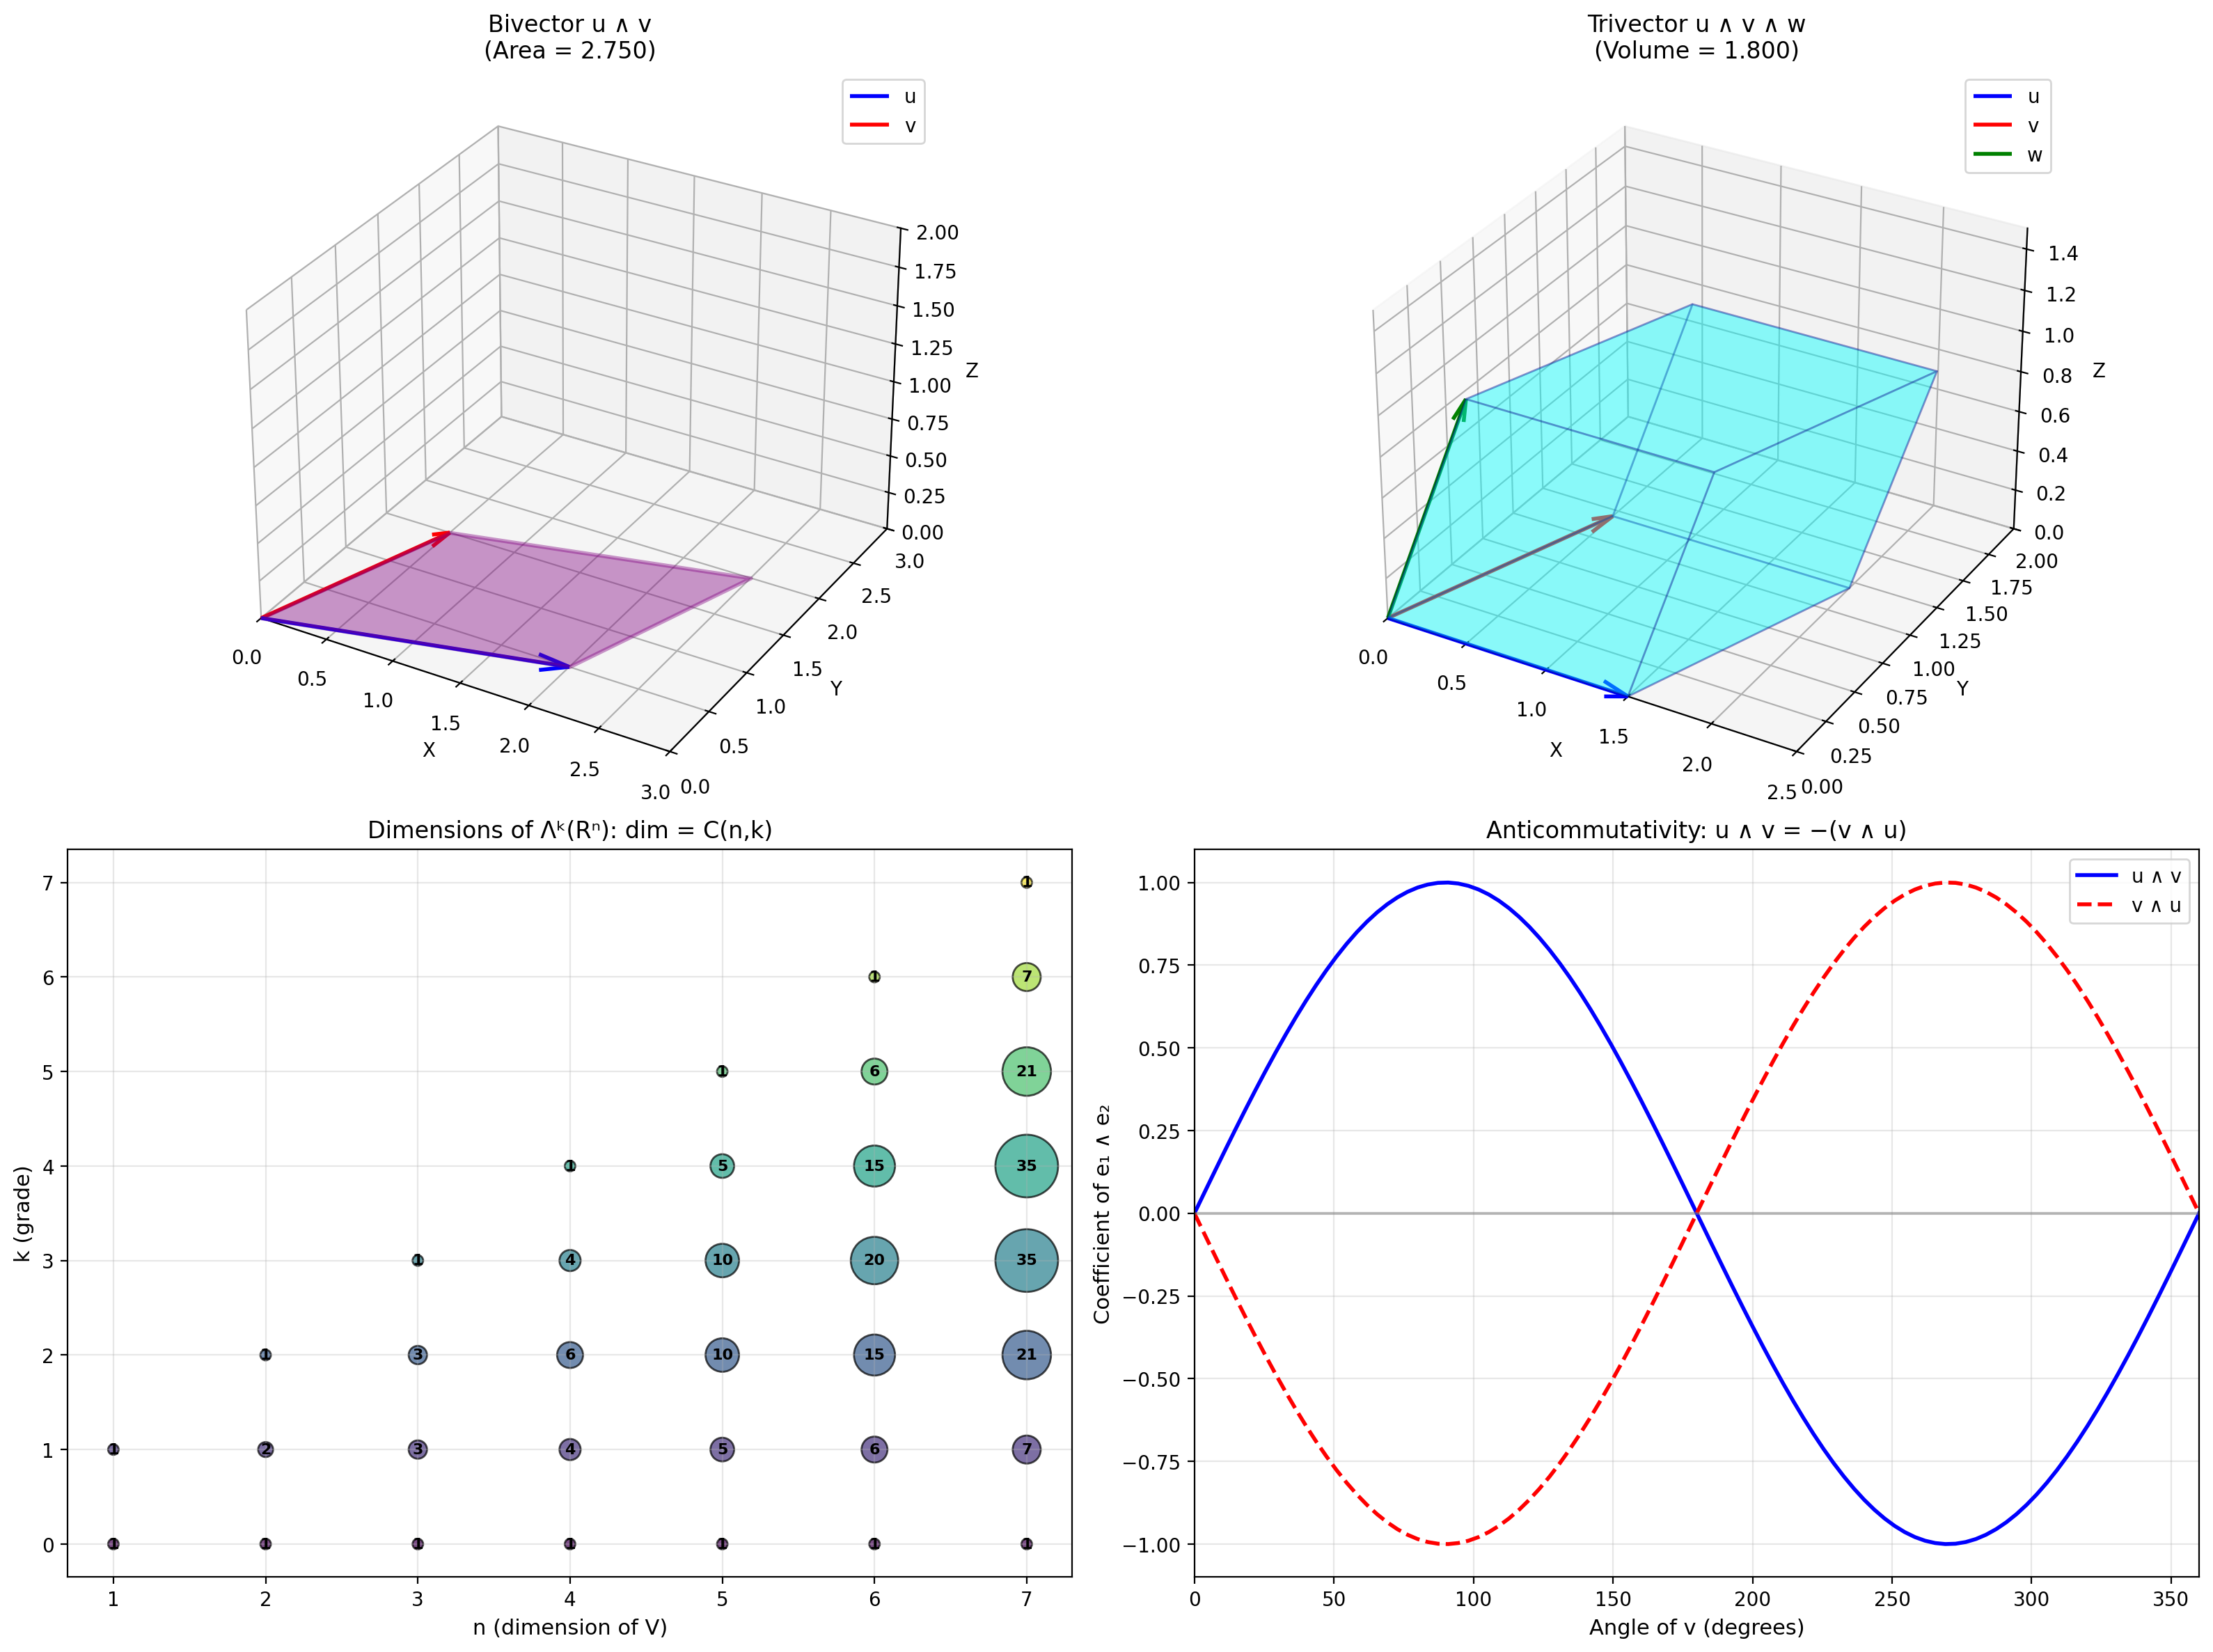


Figure saved to 'plot.png'


In [7]:
fig = plt.figure(figsize=(16, 12))

# ============================================================
# Panel 1: Bivector as oriented parallelogram
# ============================================================
ax1 = fig.add_subplot(2, 2, 1, projection='3d')

# Define vectors
u = np.array([2.0, 0.5, 0.0])
v = np.array([0.5, 1.5, 0.0])

# Plot vectors
origin = np.array([0, 0, 0])
ax1.quiver(*origin, *u, color='blue', arrow_length_ratio=0.1, linewidth=2, label='u')
ax1.quiver(*origin, *v, color='red', arrow_length_ratio=0.1, linewidth=2, label='v')

# Plot parallelogram (bivector)
parallelogram = np.array([origin, u, u + v, v, origin])
verts = [list(zip(parallelogram[:, 0], parallelogram[:, 1], parallelogram[:, 2]))]
poly = Poly3DCollection(verts, alpha=0.4, facecolor='purple', edgecolor='purple', linewidth=2)
ax1.add_collection3d(poly)

# Compute area using exterior algebra
u_ext = EA.vector_to_1form(u)
v_ext = EA.vector_to_1form(v)
bv = EA.wedge(u_ext, v_ext)
area = EA.bivector_norm(bv)

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(f'Bivector u ∧ v\n(Area = {area:.3f})', fontsize=12)
ax1.legend()
ax1.set_xlim([0, 3])
ax1.set_ylim([0, 3])
ax1.set_zlim([0, 2])

# ============================================================
# Panel 2: Trivector as oriented parallelepiped (volume)
# ============================================================
ax2 = fig.add_subplot(2, 2, 2, projection='3d')

# Define three vectors
u = np.array([1.5, 0.0, 0.0])
v = np.array([0.5, 1.2, 0.0])
w = np.array([0.3, 0.3, 1.0])

# Plot vectors
ax2.quiver(*origin, *u, color='blue', arrow_length_ratio=0.1, linewidth=2, label='u')
ax2.quiver(*origin, *v, color='red', arrow_length_ratio=0.1, linewidth=2, label='v')
ax2.quiver(*origin, *w, color='green', arrow_length_ratio=0.1, linewidth=2, label='w')

# Define parallelepiped faces
vertices = np.array([
    origin, u, u + v, v,  # Bottom face
    w, u + w, u + v + w, v + w  # Top face
])

faces = [
    [vertices[0], vertices[1], vertices[2], vertices[3]],  # Bottom
    [vertices[4], vertices[5], vertices[6], vertices[7]],  # Top
    [vertices[0], vertices[1], vertices[5], vertices[4]],  # Front
    [vertices[2], vertices[3], vertices[7], vertices[6]],  # Back
    [vertices[0], vertices[3], vertices[7], vertices[4]],  # Left
    [vertices[1], vertices[2], vertices[6], vertices[5]]   # Right
]

poly3d = Poly3DCollection(faces, alpha=0.25, facecolor='cyan', edgecolor='darkblue', linewidth=1)
ax2.add_collection3d(poly3d)

# Compute volume using exterior algebra
u_ext = EA.vector_to_1form(u)
v_ext = EA.vector_to_1form(v)
w_ext = EA.vector_to_1form(w)
uv = EA.wedge(u_ext, v_ext)
uvw = EA.wedge(uv, w_ext)
volume = abs(list(uvw.values())[0]) if uvw else 0

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title(f'Trivector u ∧ v ∧ w\n(Volume = {volume:.3f})', fontsize=12)
ax2.legend()
ax2.set_xlim([0, 2.5])
ax2.set_ylim([0, 2])
ax2.set_zlim([0, 1.5])

# ============================================================
# Panel 3: Dimension formula visualization
# ============================================================
ax3 = fig.add_subplot(2, 2, 3)

# Compute dimensions for various n
n_values = range(1, 8)
data = []
for n in n_values:
    dims = [int(comb(n, k)) for k in range(n + 1)]
    data.append(dims)

# Create Pascal-triangle-like visualization
max_n = max(n_values)
colors = plt.cm.viridis(np.linspace(0, 1, max_n + 1))

for i, n in enumerate(n_values):
    k_vals = list(range(n + 1))
    dims = data[i]
    ax3.scatter([n] * len(k_vals), k_vals, s=[d * 30 for d in dims], 
                c=[colors[k] for k in k_vals], alpha=0.7, edgecolors='black')
    for k, d in zip(k_vals, dims):
        ax3.annotate(str(d), (n, k), ha='center', va='center', fontsize=8, fontweight='bold')

ax3.set_xlabel('n (dimension of V)', fontsize=11)
ax3.set_ylabel('k (grade)', fontsize=11)
ax3.set_title('Dimensions of Λᵏ(Rⁿ): dim = C(n,k)', fontsize=12)
ax3.set_xticks(list(n_values))
ax3.set_yticks(list(range(max_n + 1)))
ax3.grid(True, alpha=0.3)

# ============================================================
# Panel 4: Anticommutativity demonstration
# ============================================================
ax4 = fig.add_subplot(2, 2, 4)

# Show how u ∧ v = -v ∧ u with varying vectors
angles = np.linspace(0, 2 * np.pi, 100)
u_fixed = np.array([1.0, 0.0, 0.0])

coeffs_uv = []
coeffs_vu = []

for angle in angles:
    v_rot = np.array([np.cos(angle), np.sin(angle), 0.0])
    u_ext = EA.vector_to_1form(u_fixed)
    v_ext = EA.vector_to_1form(v_rot)
    
    uv = EA.wedge(u_ext, v_ext)
    vu = EA.wedge(v_ext, u_ext)
    
    # Get coefficient of e1 ∧ e2
    coef_uv = uv.get((0, 1), 0)
    coef_vu = vu.get((0, 1), 0)
    
    coeffs_uv.append(coef_uv)
    coeffs_vu.append(coef_vu)

ax4.plot(np.degrees(angles), coeffs_uv, 'b-', linewidth=2, label='u ∧ v')
ax4.plot(np.degrees(angles), coeffs_vu, 'r--', linewidth=2, label='v ∧ u')
ax4.axhline(y=0, color='gray', linestyle='-', alpha=0.5)

ax4.set_xlabel('Angle of v (degrees)', fontsize=11)
ax4.set_ylabel('Coefficient of e₁ ∧ e₂', fontsize=11)
ax4.set_title('Anticommutativity: u ∧ v = −(v ∧ u)', fontsize=12)
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)
ax4.set_xlim([0, 360])

plt.tight_layout()
plt.savefig('exterior_algebra_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to 'plot.png'")

## 6. Applications

### 6.1 Computing the Cross Product via Exterior Algebra

In $\mathbb{R}^3$, the cross product can be expressed using the Hodge star operator:
$$u \times v = \star(u \wedge v)$$

The Hodge dual maps a $k$-form to an $(n-k)$-form.

In [8]:
def hodge_star_3d(bv: Dict[Tuple[int, ...], float]) -> np.ndarray:
    """
    Compute the Hodge dual of a bivector in R^3.
    Maps 2-vectors to 1-vectors (the cross product).
    
    Hodge star in R^3:
    ★(e1 ∧ e2) = e3
    ★(e2 ∧ e3) = e1  
    ★(e3 ∧ e1) = e2
    """
    result = np.zeros(3)
    
    # The Hodge star maps:
    # (0,1) -> component 2
    # (1,2) -> component 0
    # (0,2) -> -component 1 (note the sign from orientation)
    
    if (0, 1) in bv:
        result[2] = bv[(0, 1)]
    if (1, 2) in bv:
        result[0] = bv[(1, 2)]
    if (0, 2) in bv:
        result[1] = -bv[(0, 2)]  # Sign from cyclic ordering
    
    return result

# Test: cross product via exterior algebra
u = np.array([1.0, 2.0, 3.0])
v = np.array([4.0, 5.0, 6.0])

u_ext = EA.vector_to_1form(u)
v_ext = EA.vector_to_1form(v)
bv = EA.wedge(u_ext, v_ext)

cross_exterior = hodge_star_3d(bv)
cross_numpy = np.cross(u, v)

print(f"u = {u}")
print(f"v = {v}")
print()
print(f"u ∧ v = {EA.format_multivector(bv)}")
print()
print(f"u × v (via Hodge star): {cross_exterior}")
print(f"u × v (NumPy):          {cross_numpy}")
print(f"\nResults match: {np.allclose(cross_exterior, cross_numpy)}")

u = [1. 2. 3.]
v = [4. 5. 6.]

u ∧ v = -3.0000(e1 ∧ e2) - 6.0000(e1 ∧ e3) - 3.0000(e2 ∧ e3)

u × v (via Hodge star): [-3.  6. -3.]
u × v (NumPy):          [-3.  6. -3.]

Results match: True


### 6.2 Linear Independence Test

Vectors $v_1, \ldots, v_k$ are linearly independent if and only if:
$$v_1 \wedge v_2 \wedge \cdots \wedge v_k \neq 0$$

In [9]:
def test_linear_independence(vectors: List[np.ndarray]) -> bool:
    """Test if vectors are linearly independent using exterior algebra."""
    if len(vectors) == 0:
        return True
    
    EA_test = ExteriorAlgebra(len(vectors[0]))
    
    # Start with first vector
    result = EA_test.vector_to_1form(vectors[0])
    
    # Wedge with remaining vectors
    for v in vectors[1:]:
        v_ext = EA_test.vector_to_1form(v)
        result = EA_test.wedge(result, v_ext)
    
    # Vectors are independent iff wedge product is non-zero
    return len(result) > 0

# Test cases
print("Linear Independence Tests via Exterior Algebra")
print("=" * 50)

# Independent vectors
v1 = np.array([1.0, 0.0, 0.0])
v2 = np.array([0.0, 1.0, 0.0])
v3 = np.array([0.0, 0.0, 1.0])
print(f"\n{v1}, {v2}, {v3}")
print(f"Linearly independent: {test_linear_independence([v1, v2, v3])}")

# Dependent vectors (v3 = v1 + v2)
v1 = np.array([1.0, 0.0, 0.0])
v2 = np.array([0.0, 1.0, 0.0])
v3 = np.array([1.0, 1.0, 0.0])
print(f"\n{v1}, {v2}, {v3}")
print(f"Linearly independent: {test_linear_independence([v1, v2, v3])}")

# Two independent vectors in R^3
v1 = np.array([1.0, 2.0, 3.0])
v2 = np.array([4.0, 5.0, 6.0])
print(f"\n{v1}, {v2}")
print(f"Linearly independent: {test_linear_independence([v1, v2])}")

# Parallel vectors (dependent)
v1 = np.array([1.0, 2.0, 3.0])
v2 = np.array([2.0, 4.0, 6.0])
print(f"\n{v1}, {v2}")
print(f"Linearly independent: {test_linear_independence([v1, v2])}")

Linear Independence Tests via Exterior Algebra

[1. 0. 0.], [0. 1. 0.], [0. 0. 1.]
Linearly independent: True

[1. 0. 0.], [0. 1. 0.], [1. 1. 0.]
Linearly independent: False

[1. 2. 3.], [4. 5. 6.]
Linearly independent: True

[1. 2. 3.], [2. 4. 6.]
Linearly independent: False


## 7. Conclusion

Exterior algebra provides a powerful and elegant framework for:

1. **Geometric computation**: Computing areas, volumes, and higher-dimensional analogs
2. **Linear algebra**: Testing linear independence, computing determinants
3. **Differential geometry**: Foundation for differential forms and integration on manifolds
4. **Physics**: Maxwell's equations, general relativity, quantum mechanics

Key takeaways:
- The wedge product $\wedge$ is **anticommutative**: $u \wedge v = -v \wedge u$
- $k$-vectors represent **oriented $k$-dimensional parallelotopes**
- The exterior algebra is **graded**: $\Lambda(V) = \bigoplus_{k=0}^n \Lambda^k(V)$
- Dimension formula: $\dim(\Lambda^k(\mathbb{R}^n)) = \binom{n}{k}$
- The wedge product connects to the **determinant** and the **cross product**

### References

1. Grassmann, H. (1844). *Die lineale Ausdehnungslehre*
2. Flanders, H. (1963). *Differential Forms with Applications to the Physical Sciences*
3. Spivak, M. (1965). *Calculus on Manifolds*
4. Lounesto, P. (2001). *Clifford Algebras and Spinors*